# S3E24 Model Tuning
* 3 model ensemble is a blend of these three models
    * Catboost
    * XGBoost
    * LightGBM
* Other models included here but not in ensemble
    * Logistic Regression
    * Random Forest
<p>
* Note: should tune RF elsewhere since it is so slow

# Installs

In [1]:
# scienceplots produces IEEE style plots
!pip install -q scienceplots

# Imports

In [2]:
import os, glob, pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px

import scienceplots
plt.style.use(['science','no-latex'])  # not sure how to set up latex in kaggle yet.

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Read Data

In [3]:
root_dir = '/kaggle/input/playground-series-s3e24'
train = pd.read_csv(root_dir + '/train.csv')
test = pd.read_csv(root_dir + '/test.csv')
ss = pd.read_csv(root_dir + '/sample_submission.csv')

In [4]:
all_features = [col for col in test.columns if 'id' not in col]
int_features = [col for col in test.columns if 'id' not in col and test[col].dtype=='int']
float_features = [col for col in test.columns if test[col].dtype=='float']

features = all_features
features

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries']

## Cross Validation

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold

folds = 5
seed = 12

In [6]:
# if continuous, change predict_proba to predict
def run_cv_and_predict(train, test, features, model, seed):
    
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = np.zeros((test.shape[0],folds))

    # setup folding strategy
    skf = StratifiedKFold(n_splits=folds,random_state = seed,shuffle=True)
    # Use KFold if target is continuous
    #skf = KFold(n_splits=folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)[:,1]
        fold_preds = fold_preds.reshape(len(fold_preds)) # sbabwtdt
        oof[val_idx] = fold_preds

        # Compute scores
        fold_score = roc_auc_score(y_valid,fold_preds)  # CHOOSE METRIC HERE
        fold_scores.append(fold_score)
        #print(f'ROC AUC Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict_proba(test[features])[:,1]
        test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        preds[:,cur_fold-1] = test_preds  
        cur_fold +=1
    
    # Print mean fold and oof score 
    oof_score = roc_auc_score(y,oof)
    # oof_score = np.sqrt(mean_squared_error(y,oof))
    print(f'ROC AUC score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {oof_score:.5f}')
    # print(f'RMSE score: {np.mean(scores):.5f}, Stdev: {np.std(scores):.5f}, OOF score: {oof_score:.5f}')

    return (preds,fold_scores,oof_score,oof)

# Models

In [7]:
from sklearn.linear_model import LogisticRegression   # try CV too
from sklearn.metrics import roc_auc_score,roc_curve

## Split Data

In [8]:
# start with train-test split
y = train['smoking']
# x_train, x_valid, y_train, y_valid = train_test_split(train[features], y, train_size=0.8, test_size=0.2,
#                                                       random_state=12)

x_test = test[features]

## Baseline Model - Logistic Regression

In [9]:

model_lr = LogisticRegression()#C=10)
preds_lr,scores_lr,oof_score_lr,oof_lr = run_cv_and_predict(train,test,features,model_lr,seed)


# model.fit(x_train,y_train)
# val_preds = model.predict_proba(x_valid)[:,1]  
# score = roc_auc_score(y_valid, val_preds)   # make sure true is first
# print(f'ROC AUC Score = {score:.5f}')


# default lr, no feature engineering, all features, tts = .81622, lb = .81916
# int features = .80181, lb = .80703
# float features = .76748, lb = .77048
# cross validation: .81702, lb = 

ROC AUC score: 0.81705, Stdev: 0.00225, OOF score: 0.81704


## Plot ROC Curve

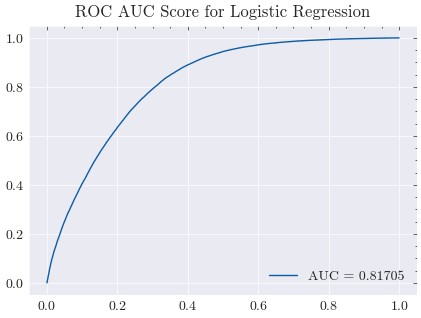

In [10]:
def plot_roc_curve(y_actual,y_preds, model_type='Unspecified'):
    plt.figure(figsize=(5,3.5))
    fpr,tpr,_ = roc_curve(y_actual,y_preds)
    plt.plot(fpr,tpr, label=f'AUC = {np.mean(scores_lr):.5}')
    plt.legend(loc='lower right')
    plt.title(f'ROC AUC Score for {model_type}')
    plt.show()
    
    
plot_roc_curve(y, oof_lr, 'Logistic Regression')

## Random Forest
* Slowest = about 4 min run time

In [11]:
# %%time
# from sklearn.ensemble import RandomForestClassifier

# model_rf = RandomForestClassifier()

# preds_rf,scores_rf,oof_score_rf,oof_rf = run_cv_and_predict(train,test,features,model_rf,seed)

# RF default ROC AUC score: 0.85248, Stdev: 0.00173, OOF score: 0.85247, lb = 
# 4 min run time

## Catboost
* About 2x speed of RF with current config, 2 min run time

In [12]:
%%time
from catboost import CatBoostClassifier

# Round 2: 1100-1500, 100 inc, learning rate: .15,.2,.25,.5, max depth: 7,9,11

# results = []

# for it in [1100,1300,1400,1800]:
#     for lr in [.07, .08,.09,.1,.15,.2]:
#         for d in [5,7,9,11,12]:
#             model_cat = CatBoostClassifier(verbose=0,n_estimators=it,learning_rate=lr,max_depth=d,task_type='GPU')
#             preds_cat, scores_cat, oof_score_cat, oof_cat = run_cv_and_predict(train,test,features,model_cat,seed)
#             print(f'est: {it}, lr: {lr}, depth: {d}, cv score: {np.mean(scores_cat)}')
        
#             results.append([it,lr,d,np.mean(scores_cat)])
            
# default ROC AUC score: 0.86531, Stdev: 0.00177, OOF score: 0.86529, lb = 
# 2 min run time
# est: 1300, lr: 0.2, depth: 11, cv score: 0.8503321291349358
# ROC AUC score: 0.86520, Stdev: 0.00183, OOF score: 0.86518

CPU times: user 43.9 ms, sys: 24.2 ms, total: 68.1 ms
Wall time: 363 ms


In [26]:
# results_df = pd.DataFrame(results,columns=['estimators','learning_rate','max_depth','cv_score'])
# results_df.head()

,estimators,learning_rate,max_depth,cv_score
0,100,0.01,3,0.821889
1,100,0.01,5,0.832586
2,100,0.01,6,0.836198
3,100,0.01,7,0.839164
4,100,0.01,9,0.844109


In [29]:
# TODO: write function to save data automatically
# results_df.to_csv('20231026_cat_tuning.csv')

In [33]:
# max_cv = results_df.cv_score.max()
# results_df[results_df.cv_score == max_cv]

0.8653003814594904

In [13]:
# import plotly.express as px

# fig = px.scatter_3d(results_df, x='estimators', y='max_depth', z='learning_rate',color='cv_score')  # scatter of 3 cols of df
# fig.update_traces(marker={'size': 3})
# fig.show(renderer='notebook')

I like that I can rotate this grid around and look at where things seem to be heading.  From this, my next set will be from 
* estimators: 1100-1500, 100 inc, learning rate: .15,.2,.25,.5, max depth: 7,9,11

 ## Cat tuning with Optuna

In [14]:
import optuna
from optuna.samplers import TPESampler

In [17]:
def objective(trial):
    
    scores = []
    
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 50, 2000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    
    # do cross validation - 5 folds
    skf = StratifiedKFold(n_splits=folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)[:,1]
        fold_score = roc_auc_score(y_valid,fold_preds) 
        scores.append(fold_score)
        #print(f'ROC AUC Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
#         test_preds = model.predict_proba(test[features])[:,1]
#         test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
#         preds[:,cur_fold-1] = test_preds 
        
        cur_fold +=1
    

    return np.mean(scores)


In [18]:
# create the study
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

In [19]:
# evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Number of finished trials:  10
Best trial:
  Value:  0.8623713954691663
  Params: 
    iterations: 863
    learning_rate: 0.0608598829841135
    depth: 4
    l2_leaf_reg: 1.0551779964424746e-05
    bootstrap_type: Bayesian
    random_strength: 2.0931628460945333e-07
    bagging_temperature: 0.923385947687978
    od_type: Iter
    od_wait: 26


In [21]:
# create model with best hyperparams
best_cat_model = CatBoostClassifier(**trial.params, verbose=False)
best_cat_model.fit(train[features], y)
cat_pred = best_cat_model.predict(x_test)

# best of 10 trials = .862

## XGBoost

In [13]:
%%time
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
preds_xgb, scores_xgb, oof_score_xgb, oof_xgb = run_cv_and_predict(train,test,features,model_xgb,seed)

# default, ROC AUC score: 0.86121, Stdev: 0.00183, OOF score: 0.86118, lb = .86831

ROC AUC Score, fold 1: 0.862248124931789
ROC AUC Score, fold 2: 0.8614510743158884
ROC AUC Score, fold 3: 0.8637063822045131
ROC AUC Score, fold 4: 0.8582744087044228
ROC AUC Score, fold 5: 0.8603516838859615
ROC AUC score: 0.86121, Stdev: 0.00183, OOF score: 0.86118
CPU times: user 2min 35s, sys: 183 ms, total: 2min 35s
Wall time: 39.8 s


## LightGBM
* super fast ~= 40 sec

In [14]:
%%time
from lightgbm import LGBMClassifier
model_lgbm = LGBMClassifier()

preds_lgbm, scores_lgbm, oof_score_lgbm, oof_lgbm = run_cv_and_predict(train,test,features,model_lgbm,seed)

# default: ROC AUC score: 0.86130, Stdev: 0.00173, OOF score: 0.86128, lb = 

ROC AUC Score, fold 1: 0.8613126551548426
ROC AUC Score, fold 2: 0.861741931054329
ROC AUC Score, fold 3: 0.8641847222791923
ROC AUC Score, fold 4: 0.8589515690884372
ROC AUC Score, fold 5: 0.8603178751378037
ROC AUC score: 0.86130, Stdev: 0.00173, OOF score: 0.86128
CPU times: user 32.1 s, sys: 3.31 s, total: 35.4 s
Wall time: 14.7 s


# Ensemble

In [15]:
# import plotly.express as px
# import random

# # model 1
# model1 = oof_cat
# preds_1 = preds_cat

# # models 2
# model2 = oof_xgb
# preds_2 = preds_xgb

# # model 3
# model3 = oof_lgbm
# preds_3 = preds_lgbm

# # model 4
# # model4 = oof_hgbc_ens
# # preds_4 = hgbc_preds

# # model 5
# # model5 = oof_lr
# # preds_5 = preds_lr

# # generate a random mix for a stochastic determination of min
# m = []
# for i in range(1000):
#     # Generate 3 random numbers to make a mix
#     a,b,c = random.random(),random.random(),random.random() #, random.random(),random.random()
#     total = a + b + c #+ d# + e
#     a /= total
#     b /= total
#     c /= total
# #     d /= total
# #     e /= total
    
#     tm_ens = a*model1 + b*model2 + c*model3 # + d*model4# + e*model5
#     tm_score = roc_auc_score(y,tm_ens)  # swap out error function here
#     m.append([a,b,c, tm_score])
    
    
# three_model = pd.DataFrame(m,columns=['a','b','c','score'])
# three_model.head()

# # find min/max score
# max_row = three_model[three_model.score == three_model.score.max()]

# # get ratios
# ratio1 = max_row.a.values[0]
# ratio2 = max_row.b.values[0]
# ratio3 = max_row.c.values[0]
# # ratio4 = max_row.d.values[0]
# #ratio5 = max_row.e.values[0]

# # predictions on test set
# preds_ens = ratio1*preds_1 + \
#             ratio2*preds_2 + \
#             ratio3*preds_3 # + \
# #             ratio4*preds_4 + \
# #            ratio5+preds_5.mean(axis=1)


# oof_3_model_ens = ratio1*oof_cat + ratio2*oof_xgb + ratio3*oof_lgbm # + ratio4*oof_hgbc_ens
# score = roc_auc_score(y,oof_3_model_ens)
# print(f'OOF score of ensemble: {score}')

## Plot Results

In [16]:
# # plotly 3d surface
# fig = px.scatter_3d(three_model, x='a', y='b', z='c',color='score',
#                    title='Score vs ratios for 3 model ensemble')  # scatter of 3 cols of df
# fig.update_traces(marker={'size': 4})  # scene=dict(zaxis=dict(range=[-5, 5]))
# fig.show(renderer='notebook')

In [17]:
# three_model.head()

In [18]:
# # sort values so best scores are on the top
# sorted_3m = three_model.sort_values(by='score',ascending=False)

# # take the mean ratios of the top 10 results
# a = sorted_3m.a[0:10].mean()
# b = sorted_3m.b[0:10].mean()
# c = sorted_3m.c[0:10].mean()
# #d = sorted_3m.d[0:10].mean()

# tot = a + b + c #+ d

# # make a prediction using the average of the top 10 ratios
# preds_ens = (a/tot)*preds_1.mean(axis=1) + (b/tot)*preds_2.mean(axis=1) + (c/tot)*preds_3.mean(axis=1) # + (d/tot)*preds_4  

# oof_3_model_ens = (a/tot)*oof_cat + (b/tot)*oof_xgb + (c/tot)*oof_lgbm # + (d/tot)*oof_hgbc_ens
# score = roc_auc_score(y,oof_3_model_ens)
# print(f'OOF score of ensemble: {score:.5f}')


## Select Preds

In [19]:
#final_preds = preds_lgbm.mean(axis=1)

final_preds = preds_ens
final_preds

NameError: name 'preds_ens' is not defined

# Submission
* Check submission CV vs LB

In [ ]:
ss.smoking = final_preds
ss.to_csv('submission.csv',index=False)
ss.head(3)

In [ ]:
plt.figure(figsize=(5,3.5))
ss.smoking.plot(kind='hist',bins=50)
plt.title('Test Predictions');